In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

step 1: normalize all of your trading signals so that they have the same units -- e.g., that they fall between -1 and 1, or z-scored, or some sensible unitization like that. 

step 2: compute the following: signal(t)*assetReturn(t+1) = positionReturn(t+1), for each signal and each asset. Note, all information (e.g., price data) used to generate signal(t) needs to be time-stamped from BEFORE the close of trading in period t.

step 3: compute the correlations across your positionReturn data

step 4: compute the cumulative PnL over your entire sample of your positionReturn(t); cumPnL(t) = positionReturn(t)*(1 + cumPnL(t-1) ). For period t=0 set cumPnL(0) = 1.

Examine your cumulative PnLs to see which signals are profitable during your sample; combine your signals (i.e., determine weights) using the logic from you lecture notes on portfolio construction

In [2]:
file_path_f = '../data/carry1_data.xlsx'
columns_to_read = 'A:E'
df_f = pd.read_excel(file_path_f, sheet_name='carry1_adj', skiprows=0, usecols=columns_to_read)
df_f.rename(columns={df_f.columns[0]: "Dates"}, inplace=True)
df_f1 = df_f.drop(index=0).reset_index(drop=True)
df_f1["Dates"] = pd.to_datetime(df_f1["Dates"]).dt.strftime("%m/%d/%Y")

file_path_f = '../data/carry2_data.xlsx'
columns_to_read = 'A:E'
df_f = pd.read_excel(file_path_f, sheet_name='carry2_adj', skiprows=0, usecols=columns_to_read)
df_f.rename(columns={df_f.columns[0]: "Dates"}, inplace=True)
df_f2 = df_f.drop(index=0).reset_index(drop=True)
df_f2["Dates"] = pd.to_datetime(df_f2["Dates"]).dt.strftime("%m/%d/%Y")

df_f2 = df_f2.rename(columns=lambda x: f"{x}2" if x != "Dates" else x)
combined_df = pd.concat([df_f1, df_f2.iloc[:, 1:]], axis=1)
combined_df.head()

,Dates,Carry NG1 Comdty - NG2 Comdty,Carry NG1 Comdty - NG3 Comdty,Carry NG1 Comdty - NG4 Comdty,Carry NG1 Comdty - NG6 Comdty,Carry NG1 Comdty - NG2 Comdty2,Carry NG1 Comdty - NG3 Comdty2,Carry NG1 Comdty - NG4 Comdty2,Carry NG1 Comdty - NG6 Comdty2
0,11/02/2004,17.909500,-8.035000,-17.634500,-18.929500,-0.000377,-0.001153,-0.005316,-0.036515
1,11/03/2004,-8.245000,7.952000,16.785667,17.845667,0.001235,0.001245,0.006853,0.027944
2,11/04/2004,75.289500,-38.577000,-84.947500,-89.913250,-0.002807,-0.005977,-0.057454,-0.261620
3,11/05/2004,157.441200,-27.212000,-110.103600,-119.884200,0.002312,0.003739,-0.008826,-0.242755
4,11/08/2004,234.425167,-34.756667,-159.007167,-172.678500,0.004378,0.008041,-0.017386,-0.329517


In [3]:
def convert_to_quantile(series, window):
    """
    Converts each value in the series to its quantile based on the rolling window of historical data
    """
    return series.rolling(window).apply(
        lambda x: (x.rank(pct=True).iloc[-1]) if len(x) == window else np.nan
    )

In [4]:
window = 3
converted_df = combined_df.copy()
for col in combined_df.columns[1:]:  # Skip the "Dates" column
    converted_df[col] = convert_to_quantile(combined_df[col], window)
    converted_df[col] = (converted_df[col] - 0.5 * (1 + 1 / window)) * 2 / (1 - 1 / window)
converted_df.dropna(inplace=True)
converted_df.head()

,Dates,Carry NG1 Comdty - NG2 Comdty,Carry NG1 Comdty - NG3 Comdty,Carry NG1 Comdty - NG4 Comdty,Carry NG1 Comdty - NG6 Comdty,Carry NG1 Comdty - NG2 Comdty2,Carry NG1 Comdty - NG3 Comdty2,Carry NG1 Comdty - NG4 Comdty2,Carry NG1 Comdty - NG6 Comdty2
2,11/04/2004,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,11/05/2004,1.0,0.0,-1.0,-1.0,1.0,1.0,0.0,0.0
4,11/08/2004,1.0,0.0,-1.0,-1.0,1.0,1.0,0.0,-1.0
5,11/09/2004,1.0,-1.0,-1.0,-1.0,1.0,0.0,0.0,-1.0
6,11/10/2004,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0


In [5]:
# converted_df = combined_df.copy()
# for col in converted_df.columns[1:]:  # Skip the "Dates" column
#     converted_df[col] = converted_df[col].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)

# converted_df.head()

In [6]:
# # Function to compute Z-score based on a rolling window
def convert_to_zscore(series, window):
    """
    Converts each value in the series to its Z-score based on the rolling window of historical data.
    """
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    return (series - rolling_mean) / rolling_std

# window = 20
# converted_df = combined_df.copy()

# for col in combined_df.columns[1:]:  # Skip the "Dates" column
#     converted_df[col] = convert_to_zscore(combined_df[col], window)

# converted_df.dropna(inplace=True)  # Drop rows with NaN values
# converted_df.head()

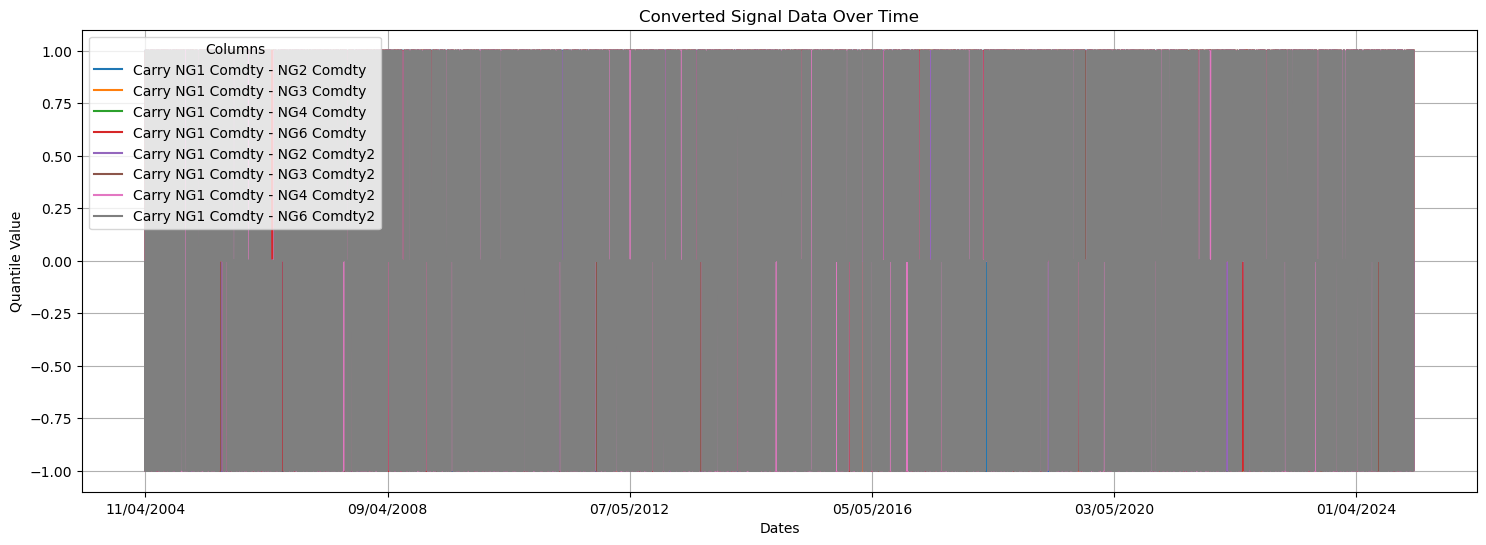

In [7]:
converted_df.set_index('Dates').plot(
    figsize=(18, 6), title="Converted Signal Data Over Time"
)
plt.xlabel("Dates")
plt.ylabel("Quantile Value")
plt.legend(loc='upper left', title="Columns")
plt.grid(True)
plt.show()

In [8]:
file_path_p = '../data/NG1_data.xlsx'
df_price = pd.read_excel(file_path_p, sheet_name='fullHistory', skiprows=3, usecols='B:G')
df_price.rename(columns={df_price.columns[0]: "Dates"}, inplace=True)
df_price = df_price.drop(index=0).reset_index(drop=True)
df_price["Dates"] = pd.to_datetime(df_price["Dates"]).dt.strftime("%m/%d/%Y")
df_price.head()

,Dates,NG1 Comdty,NG2 Comdty,NG3 Comdty,NG4 Comdty,NG6 Comdty
0,11/01/2004,2183.719,4642.824,1554.613,209.742,59.307
1,11/02/2004,2145.403,4568.689,1532.367,206.695,58.85
2,11/03/2004,2191.732,4645.295,1558.733,210.211,59.481
3,11/04/2004,2053.246,4398.178,1479.635,201.774,58.725
4,11/05/2004,1991.892,4215.312,1413.719,193.102,57.313


In [9]:
# # pre-2022
# df_price = df_price.iloc[:4480]
# df_price.tail()

In [10]:
def factors_return(converted_df, df_price, one_factor=0):
    # Step 2: Compute asset returns
    df_price['AssetReturn'] = df_price['NG1 Comdty'].pct_change().shift(-1)

    # Merge signals with asset returns based on the date
    converted_df['Dates'] = pd.to_datetime(converted_df['Dates'])
    df_price['Dates'] = pd.to_datetime(df_price['Dates'])
    merged_df = pd.merge(converted_df, df_price[['Dates', 'AssetReturn']], on='Dates')


    # Compute position returns for each signal
    signal_columns = [col for col in converted_df.columns if col != 'Dates']
    for signal in signal_columns:
        merged_df[f'PositionReturn_{signal}'] = merged_df[signal] * merged_df['AssetReturn']

    # Step 3: Compute correlations across PositionReturns
    position_return_columns = [col for col in merged_df.columns if col.startswith('PositionReturn')]
    correlation_matrix = merged_df[position_return_columns].corr()

    # Step 4: Compute cumulative PnL
    cum_pnl = pd.DataFrame({'Dates': merged_df['Dates']})
    for signal in position_return_columns:
        cum_pnl[f'CumPnL_{signal}'] = (1 + merged_df[signal]).cumprod()

    cum_pnl.set_index("Dates", inplace=True)

    plt.figure(figsize=(12, 6))
    for column in cum_pnl.columns:
        plt.plot(cum_pnl.index, cum_pnl[column], label=column.replace('CumPnL_PositionReturn_', ''), linewidth=1)

    plt.plot(cum_pnl.index, (1 + merged_df['AssetReturn']).cumprod(), label='Long NG1 return', linewidth=1)


    plt.title('Cumulative PnL Over Time', fontsize=16)
    plt.ylabel('Cumulative PnL', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(title='Signals', fontsize=10)
    plt.grid(True)

    # Adjust x-tick density
    plt.xticks(cum_pnl.index[::180], rotation=45)  # Show every 2nd date and rotate labels for better visibility

    plt.tight_layout()
    plt.show()

    cum_pnl_columns = [col for col in cum_pnl.columns if col != 'Dates']
    # cum_pnl_correlation = cum_pnl[cum_pnl_columns].corr()

    if one_factor == 0:
        # Visualize the correlation matrix as a heatmap
        plt.figure(figsize=(10, 8))
        plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
        plt.colorbar(label='Correlation Coefficient')
        plt.title('Correlation Matrix of Daily PnL', fontsize=16)

        # Adding labels
        plt.xticks(
            range(len(cum_pnl_columns)), 
            labels=[col.replace('CumPnL_PositionReturn_', '') for col in cum_pnl_columns], 
            rotation=30, 
            fontsize=12
        )
        plt.yticks(
            range(len(cum_pnl_columns)), 
            labels=[col.replace('CumPnL_PositionReturn_', '') for col in cum_pnl_columns], 
            rotation=0,  # Typically y-ticks are not rotated
            fontsize=12
        )

        plt.tight_layout()
        plt.show()

    # Reset index to ensure calculations work smoothly
    cum_pnl.dropna(inplace=True)
    cum_pnl.reset_index(inplace=True)


    # Compute daily returns from cumulative PnL
    daily_returns = cum_pnl.drop(columns=["Dates"]).pct_change()

    # Initialize a dictionary to store metrics for each signal
    metrics = {}

    # Iterate over each signal
    for signal in daily_returns.columns:
        signal_pnl = cum_pnl[signal]
        signal_daily_return = daily_returns[signal].dropna()
        
        # Strategy Cumulative Return
        cumulative_return = signal_pnl.iloc[-1]
        
        # Strategy Annual Return
        num_years = len(cum_pnl) / 252
        annual_return = (signal_pnl.iloc[-1] / signal_pnl.iloc[0]) ** (1 / num_years) - 1
        
        # Annual Volatility
        annual_volatility = signal_daily_return.std() * (252 ** 0.5)
        
        # Sharpe Ratio
        sharpe_ratio = signal_daily_return.mean() / signal_daily_return.std() * (252 ** 0.5)
        
        # Max Drawdown
        running_max = signal_pnl.cummax()
        drawdown = (running_max - signal_pnl) / running_max
        max_drawdown = drawdown.max()
        
        # Win Rate
        win_rate = (signal_daily_return > 0).sum() / len(signal_daily_return)
        
        # Sortino Ratio
        downside_deviation = signal_daily_return[signal_daily_return < 0].std()
        sortino_ratio = (signal_daily_return.mean() / downside_deviation) * (252 ** 0.5)
        
        # Record metrics for this signal
        metrics[signal] = {
            "Strategy Annual Return": annual_return,
            "Strategy Cumulative Return": cumulative_return,
            "Annual Sharpe Ratio": sharpe_ratio,
            "Annual Volatility": annual_volatility,
            "Max Drawdown %": max_drawdown * 100,
            "Win Rate %": win_rate * 100,
            "Annual Sortino Ratio": sortino_ratio,
        }

    return pd.DataFrame(metrics)

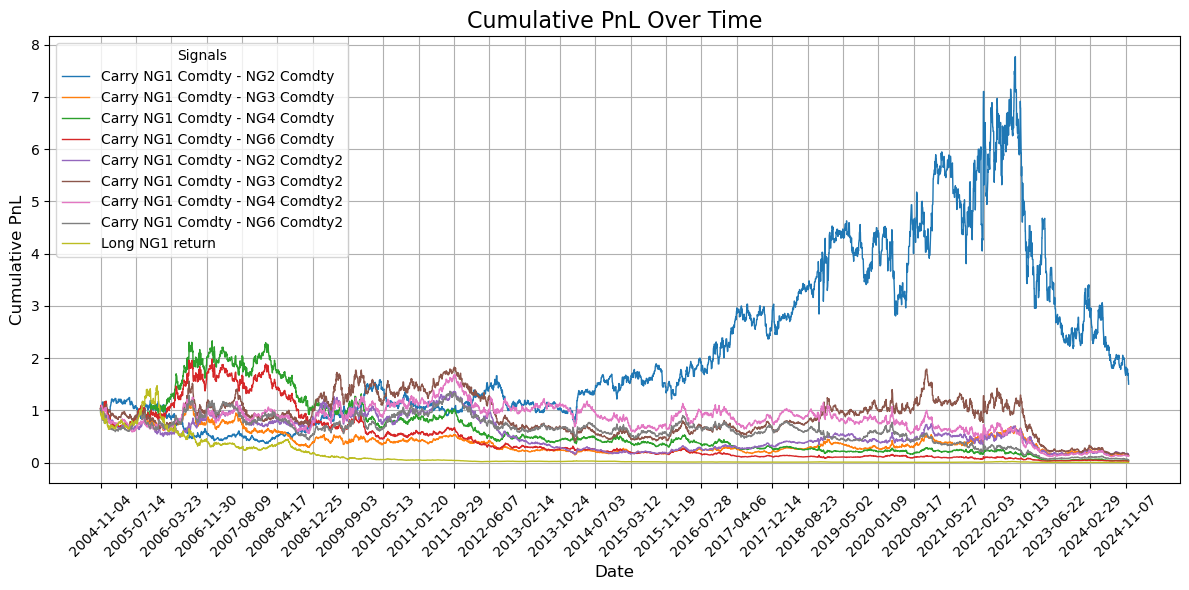

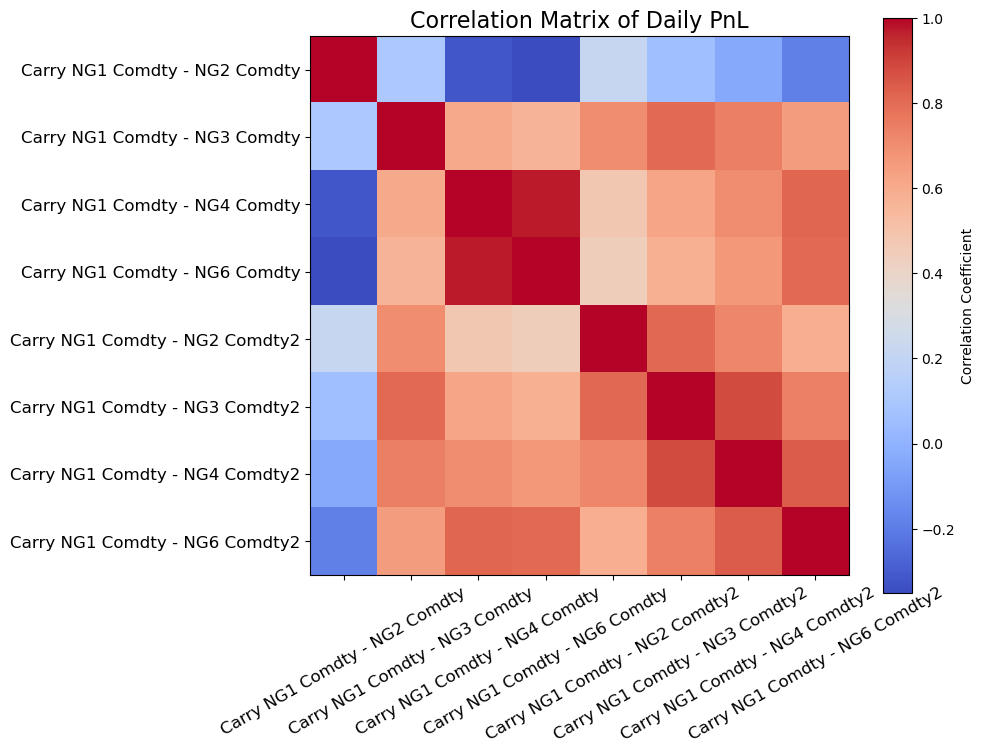

,CumPnL_PositionReturn_Carry NG1 Comdty - NG2 Comdty,CumPnL_PositionReturn_Carry NG1 Comdty - NG3 Comdty,CumPnL_PositionReturn_Carry NG1 Comdty - NG4 Comdty,CumPnL_PositionReturn_Carry NG1 Comdty - NG6 Comdty,CumPnL_PositionReturn_Carry NG1 Comdty - NG2 Comdty2,CumPnL_PositionReturn_Carry NG1 Comdty - NG3 Comdty2,CumPnL_PositionReturn_Carry NG1 Comdty - NG4 Comdty2,CumPnL_PositionReturn_Carry NG1 Comdty - NG6 Comdty2
Strategy Annual Return,0.021176,-0.095055,-0.150123,-0.167788,-0.088927,-0.092875,-0.097412,-0.136850
Strategy Cumulative Return,1.499397,0.129269,0.035072,0.022668,0.148726,0.135895,0.122450,0.048395
Annual Sharpe Ratio,0.272321,0.008054,-0.133044,-0.178516,0.028102,0.017377,0.009252,-0.095167
Annual Volatility,0.456528,0.457605,0.454193,0.454620,0.462339,0.461035,0.463683,0.457053
Max Drawdown %,80.705724,89.346302,98.557900,98.855349,89.676066,92.561335,93.484569,96.449755
Win Rate %,36.676218,35.721108,35.090735,34.842407,36.275072,36.007641,36.217765,35.568290
Annual Sortino Ratio,0.348549,0.010753,-0.172202,-0.229230,0.036482,0.022486,0.011864,-0.122480


In [11]:
factors_return(converted_df, df_price)

In [12]:
technical_df = pd.read_csv('../data/NG1_Comdty_technical_indicators.csv', parse_dates=['Dates'])
technical_df['SMA_crossover'] = technical_df['SMA_crossover'].apply(lambda x: -1 if x == 0 else x)
technical_df.head()

,Dates,SMA_50,SMA_200,SMA_crossover,DEMA,MACD,MACD_Signal,RSI,ROC,BIAS,Z_Score,Keltner_upper,Keltner_lower,Bollinger_upper,Bollinger_lower
0,2004-11-01,NaN,NaN,-1,2183.719000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-11-02,NaN,NaN,-1,2176.768252,-3.056547,-0.611309,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-11-03,NaN,NaN,-1,2179.198272,-1.720684,-0.833184,54.733298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-11-04,NaN,NaN,-1,2156.178980,-11.701776,-3.006903,20.763139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-11-05,NaN,NaN,-1,2125.271913,-24.282702,-7.262062,16.285217,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
window = 60
# combined_df = pd.merge(carry_df, technical_df, on=['Dates'])
converted_df2 = technical_df.copy()
for col in technical_df.columns[1:3]:
    converted_df2[col] = convert_to_quantile(technical_df[col], window)
    converted_df2[col] = (converted_df2[col] - 0.5 * (1 + 1 / window)) * 2 / (1 - 1 / window)
    # converted_df2[col] = convert_to_zscore(technical_df[col], window)
for col in technical_df.columns[4:]:
    converted_df2[col] = convert_to_quantile(technical_df[col], window)
    converted_df2[col] = (converted_df2[col] - 0.5 * (1 + 1 / window)) * 2 / (1 - 1 / window)
converted_df2.dropna(inplace=True)
converted_df2.head()

,Dates,SMA_50,SMA_200,SMA_crossover,DEMA,MACD,MACD_Signal,RSI,ROC,BIAS,Z_Score,Keltner_upper,Keltner_lower,Bollinger_upper,Bollinger_lower
258,2005-10-27,1.0,1.0,1,0.728814,-0.796610,-0.762712,-0.694915,-0.661017,-0.661017,-0.389831,1.000000,1.000000,0.423729,1.000000
259,2005-10-28,1.0,1.0,1,0.525424,-0.966102,-0.830508,-0.762712,-0.762712,-0.898305,-0.898305,1.000000,0.932203,0.355932,0.898305
260,2005-10-31,1.0,1.0,1,0.322034,-1.000000,-0.898305,-0.898305,-1.000000,-1.000000,-1.000000,0.932203,0.661017,0.389831,0.796610
261,2005-11-01,1.0,1.0,1,0.220339,-1.000000,-0.966102,-0.932203,-1.000000,-1.000000,-1.000000,0.830508,0.525424,0.389831,0.627119
262,2005-11-02,1.0,1.0,1,0.152542,-1.000000,-1.000000,-0.898305,-0.966102,-1.000000,-0.966102,0.728814,0.322034,0.423729,0.559322


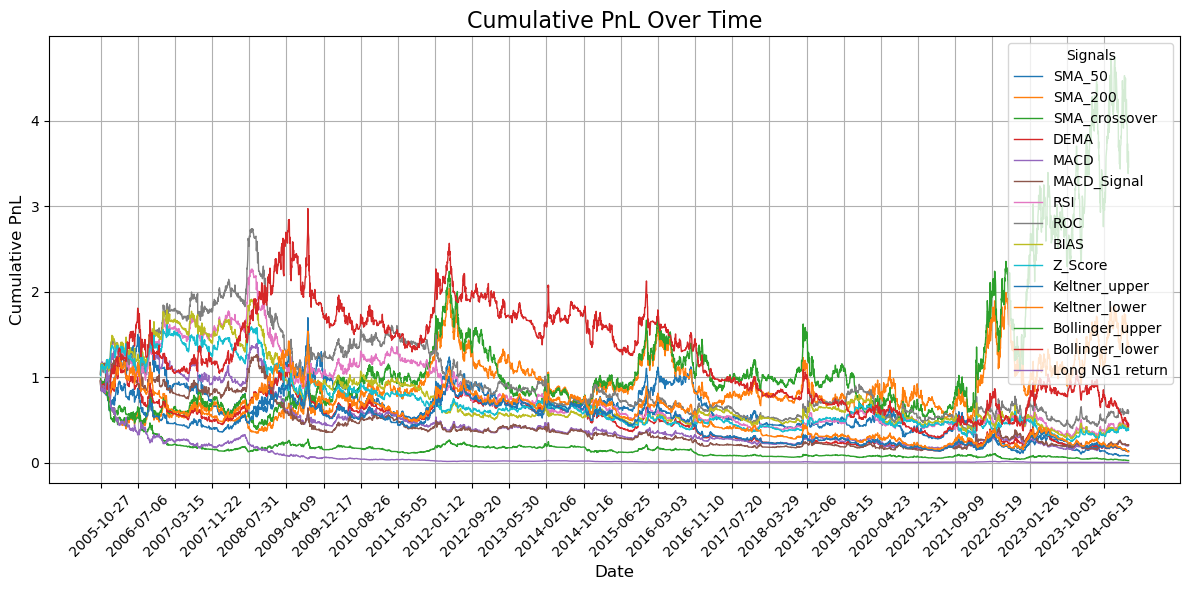

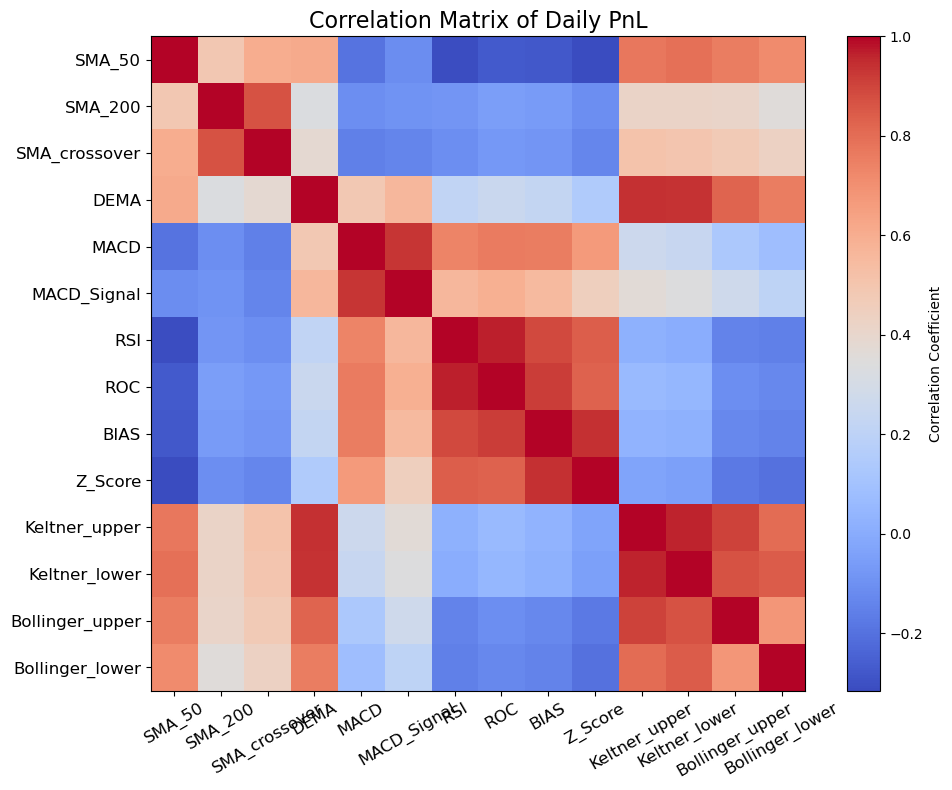

,CumPnL_PositionReturn_SMA_50,CumPnL_PositionReturn_SMA_200,CumPnL_PositionReturn_SMA_crossover,CumPnL_PositionReturn_DEMA,CumPnL_PositionReturn_MACD,CumPnL_PositionReturn_MACD_Signal,CumPnL_PositionReturn_RSI,CumPnL_PositionReturn_ROC,CumPnL_PositionReturn_BIAS,CumPnL_PositionReturn_Z_Score,CumPnL_PositionReturn_Keltner_upper,CumPnL_PositionReturn_Keltner_lower,CumPnL_PositionReturn_Bollinger_upper,CumPnL_PositionReturn_Bollinger_lower
Strategy Annual Return,-0.118039,0.016907,0.067333,-0.095669,-0.079779,-0.078116,-0.041527,-0.027457,-0.045788,-0.048459,-0.094759,-0.097255,-0.171858,-0.039504
Strategy Cumulative Return,0.079674,1.328869,3.458875,0.132426,0.200409,0.207379,0.446234,0.594297,0.408004,0.381339,0.133342,0.126260,0.023590,0.430100
Annual Sharpe Ratio,-0.019593,0.291537,0.387750,-0.057388,-0.040362,-0.028582,0.045419,0.094269,0.038505,0.005465,-0.030590,-0.032651,-0.254051,0.098044
Annual Volatility,0.475456,0.520209,0.532966,0.393917,0.369948,0.377009,0.342131,0.351933,0.348813,0.321331,0.415814,0.419813,0.409824,0.397336
Max Drawdown %,95.485820,75.618657,78.138732,88.893050,90.633738,89.850681,86.779237,86.806811,85.413327,84.678644,87.376262,91.816568,97.612201,90.227742
Win Rate %,48.253012,49.397590,49.598394,47.248996,47.791165,46.465863,47.469880,47.630522,47.510040,47.630522,47.048193,47.269076,46.907631,48.152610
Annual Sortino Ratio,-0.024568,0.409436,0.561661,-0.074147,-0.052146,-0.037900,0.060349,0.125482,0.050257,0.007156,-0.040026,-0.042457,-0.325880,0.127550


In [14]:
factors_return(converted_df2, df_price)

In [15]:
converted_df['Dates'] = pd.to_datetime(converted_df['Dates'])
converted_df2['Dates'] = pd.to_datetime(converted_df2['Dates'])

signals_df = pd.merge(converted_df[['Dates', 'Carry NG1 Comdty - NG2 Comdty']], converted_df2[['Dates', 'SMA_crossover']], on='Dates')
signals_df.head()

,Dates,Carry NG1 Comdty - NG2 Comdty,SMA_crossover
0,2005-10-27,1.0,1
1,2005-10-28,1.0,1
2,2005-10-31,1.0,1
3,2005-11-01,1.0,1
4,2005-11-02,1.0,1


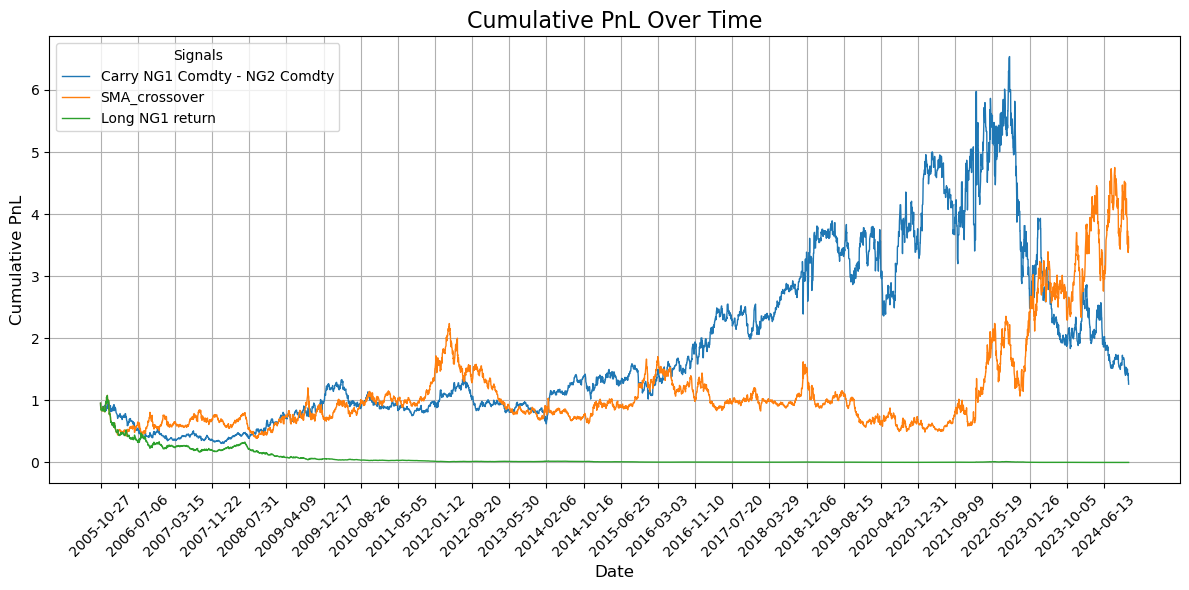

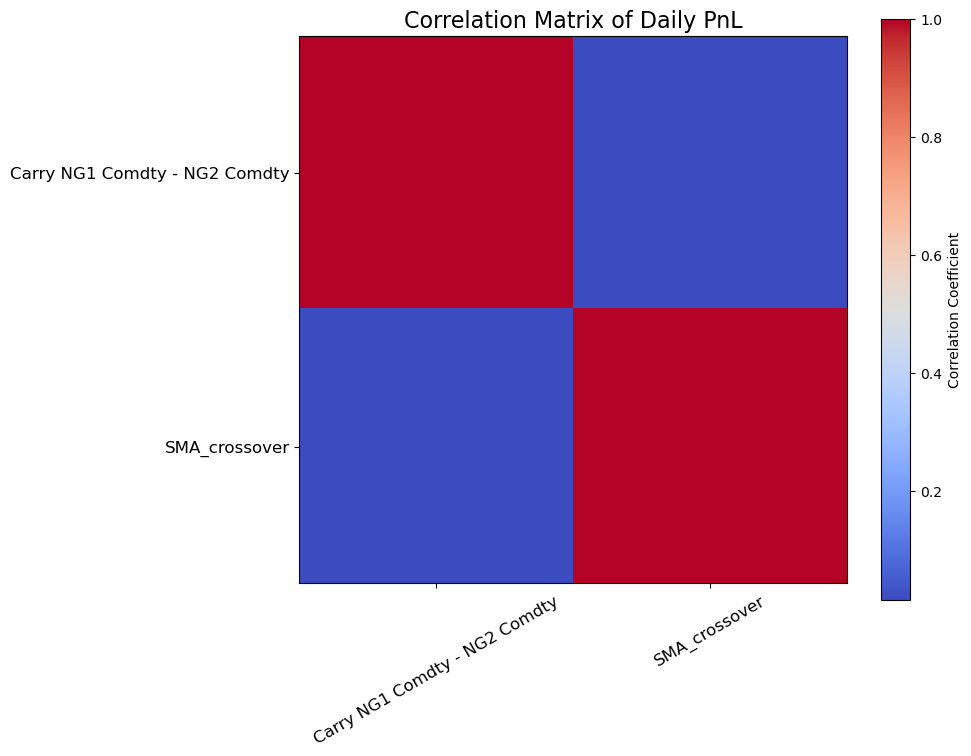

,CumPnL_PositionReturn_Carry NG1 Comdty - NG2 Comdty,CumPnL_PositionReturn_SMA_crossover
Strategy Annual Return,0.014229,0.067333
Strategy Cumulative Return,1.261374,3.458875
Annual Sharpe Ratio,0.257406,0.387750
Annual Volatility,0.457010,0.532966
Max Drawdown %,80.705724,78.138732
Win Rate %,36.666667,49.598394
Annual Sortino Ratio,0.331402,0.561661


In [16]:
factors_return(signals_df, df_price)

In [17]:
def combine_factors_with_softmax(converted_df, df_price, lookback_period=60, weight_adjust_interval=10):
    """
    Combines factors dynamically using softmax weights based on historical signal mean returns.
    
    Parameters:
    - converted_df: DataFrame with columns ['Dates', 'signal1', 'signal2', ...].
    - df_price: DataFrame with columns ['Dates', 'AssetPrice'] for calculating returns.
    - lookback_period: Integer, number of days for the historical mean return calculation.
    - weight_adjust_interval: Integer, number of days between weight adjustments.

    Returns:
    - combined_signal_df: DataFrame with columns ['Dates', 'Signal'].
    """
    # Step 1: Calculate asset returns
    df_price['AssetReturn'] = df_price['NG1 Comdty'].pct_change().shift(-1)

    # Merge signals with asset returns based on the date
    converted_df['Dates'] = pd.to_datetime(converted_df['Dates'])
    df_price['Dates'] = pd.to_datetime(df_price['Dates'])
    merged_df = pd.merge(converted_df, df_price[['Dates', 'AssetReturn']], on='Dates', how='inner')

    # Get signal columns
    signal_columns = [col for col in converted_df.columns if col != 'Dates']
    
    # Step 2: Calculate position returns for each signal
    for signal in signal_columns:
        merged_df[f'PositionReturn_{signal}'] = merged_df[signal] * merged_df['AssetReturn']

    # Step 3: Calculate rolling mean returns and softmax weights
    weight_columns = []
    for signal in signal_columns:
        # Historical mean return (look-back period, excluding today's return)
        merged_df[f'MeanReturn_{signal}'] = (
            merged_df[f'PositionReturn_{signal}'].shift(1).rolling(lookback_period).mean()
        )
        weight_columns.append(f'MeanReturn_{signal}')

    # Apply softmax weighting every `weight_adjust_interval` days
    def calculate_weights(row):
        means = row[weight_columns].values
        exp_means = np.exp(means)
        return exp_means / np.sum(exp_means)

    merged_df['WeightUpdateFlag'] = (merged_df.index % weight_adjust_interval == 0)
    weights_df = merged_df[weight_columns].apply(calculate_weights, axis=1, result_type='expand')
    weights_df.columns = [f'Weight_{signal}' for signal in signal_columns]

    # Fill forward weights for non-update days
    for col in weights_df.columns:
        weights_df[col] = weights_df[col].where(merged_df['WeightUpdateFlag']).fillna(method='ffill')
    
    # Step 4: Combine signals using weights
    merged_df = pd.concat([merged_df, weights_df], axis=1)
    merged_df['CombinedSignal'] = sum(
        merged_df[f'Weight_{signal}'] * merged_df[signal] for signal in signal_columns
    )

    # Step 5: Prepare the final output
    combined_signal_df = merged_df[['Dates', 'CombinedSignal']]
    
    return combined_signal_df

In [18]:
new_signal = combine_factors_with_softmax(signals_df, df_price, 22*6, 22)
new_signal['CombinedSignal'] = round(new_signal['CombinedSignal'], 1)
new_signal['CombinedSignal'].value_counts()

CombinedSignal
 0.0    1799
-1.0    1364
-0.5     913
 1.0     458
 0.5     316
Name: count, dtype: int64

In [19]:
new_signal['Dates'] = pd.to_datetime(new_signal['Dates'])
signals_df['Dates'] = pd.to_datetime(signals_df['Dates'])

all_signals_df = pd.merge(signals_df, new_signal, on='Dates')
all_signals_df.dropna(inplace=True)
all_signals_df.head()

,Dates,Carry NG1 Comdty - NG2 Comdty,SMA_crossover,CombinedSignal
132,2006-05-01,-1.0,-1,-1.0
133,2006-05-02,-1.0,-1,-1.0
134,2006-05-03,1.0,-1,0.0
135,2006-05-04,-1.0,-1,-1.0
136,2006-05-05,0.0,-1,-0.5


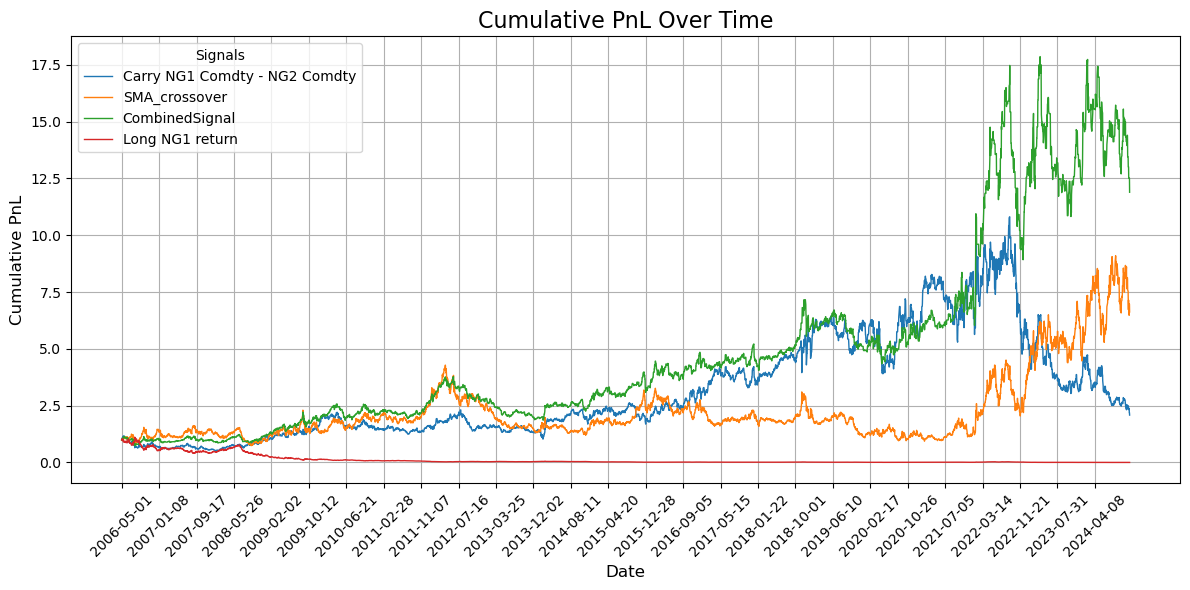

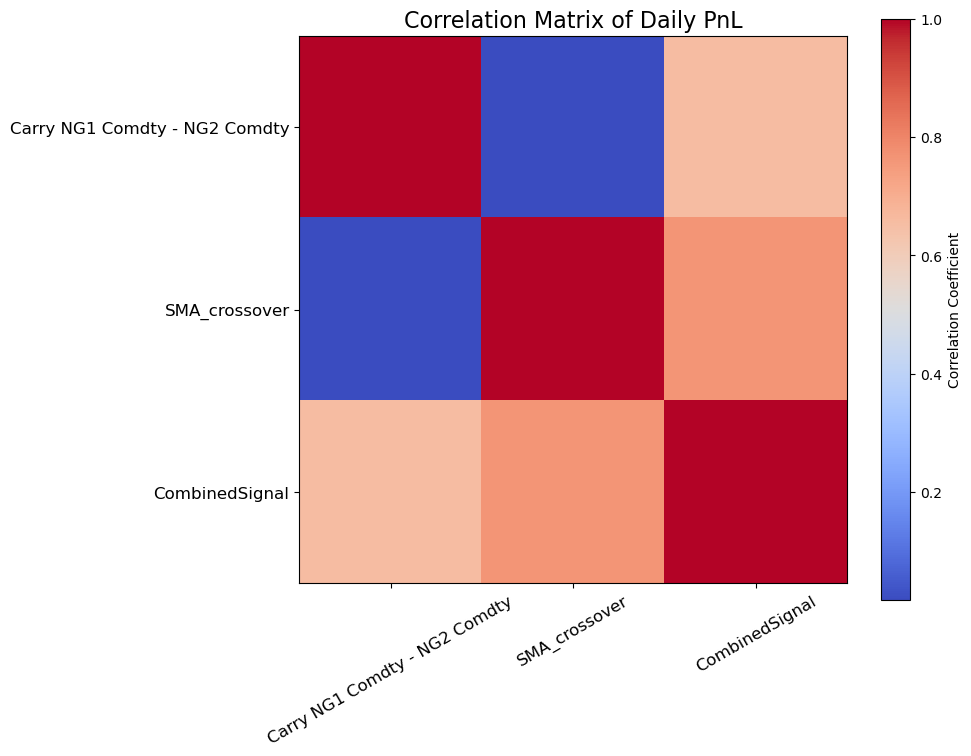

,CumPnL_PositionReturn_Carry NG1 Comdty - NG2 Comdty,CumPnL_PositionReturn_SMA_crossover,CumPnL_PositionReturn_CombinedSignal
Strategy Annual Return,0.039352,0.103668,0.137759
Strategy Cumulative Return,2.085566,6.621895,11.890574
Annual Sharpe Ratio,0.310255,0.450275,0.539366
Annual Volatility,0.455311,0.531300,0.352723
Max Drawdown %,80.705724,78.138732,50.697389
Win Rate %,36.654290,49.876238,31.786304
Annual Sortino Ratio,0.400809,0.651119,0.615419


In [20]:
factors_return(all_signals_df, df_price)

In [21]:
# all_signals_df.to_csv("../data/CombinedSignal.csv")